In [1]:
import numpy as np 
import pandas as pd
import vrplib
import collections
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from nn_2opt import nearest_neighbor_with_2opt

In [2]:
# read VRPLIB formatted instances (default)

instance = vrplib.read_instance("C:/Users/cevat/Desktop/assignment/CVRP-Heuristics-Lab/Vrp-Set-D/Vrp-Set-D/D/ORTEC-n242-k12.vrp")
solution = vrplib.read_solution("C:/Users/cevat/Desktop/assignment/CVRP-Heuristics-Lab/Vrp-Set-D/Vrp-Set-D/D/ORTEC-n242-k12.sol")
instance.keys()

dict_keys(['name', 'comment', 'type', 'dimension', 'edge_weight_type', 'edge_weight_format', 'node_coord_type', 'capacity', 'edge_weight', 'node_coord', 'demand', 'depot'])

In [3]:
solution["cost"]

123750

In [4]:
vehicle_count=round(sum(instance["demand"])/ instance["capacity"]*2)
edge_weight = instance["edge_weight"]
demand = instance["demand"]
node_count = len(demand)
vehicle_capacity = instance["capacity"]

In [6]:
#Initial variable count for all possible node-node-vehicle combinations
node_count*node_count*vehicle_count

1405536

In [16]:
# Get the warm start solution from nearest neighbor
initial_solution = nearest_neighbor_with_2opt(instance)


In [19]:
def create_optimized_variables(initial_solution, coordinates, distance_threshold, vehicle_count, capacities):
    node_count = len(coordinates)
    x_vars = {}  # Dictionary to store only the needed variables

    # Calculate distances between nodes
    distances = np.zeros((node_count, node_count))
    for i in range(node_count):
        for j in range(i + 1, node_count):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            distances[i, j] = distance
            distances[j, i] = distance

    # Iterate through all possible arcs and vehicles
    for i in range(node_count):
        for j in range(node_count):
            if i != j:
                for k in range(vehicle_count):
                    # Only add variables that are promising based on heuristics
                    if (i, j) in initial_solution.get(k, []):
                        x_vars[(i, j, k)] = 1
                    elif distances[i, j] <= distance_threshold:
                        demand_i = demand[i]
                        demand_j = demand[j]
                        if demand_i + demand_j <= capacities[k]:  # Check capacity constraint
                            x_vars[(i, j, k)] = 1


    return x_vars

In [60]:
def visualize_routes(solution, coordinates):

    plt.figure(figsize=(12, 8))

    # Plot depot
    depot = coordinates[0]
    plt.scatter(depot[0], depot[1], color='red', marker='s', s=100, label='Depot')
    
    # Plot customers
    customer_coords = instance["node_coord"][1:]
    for idx, coord in enumerate(customer_coords, start=1):
        plt.scatter(coord[0], coord[1], color='black')

    # Plot routes for each vehicle
    colors = ['green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']
    vehicle_labels = set() 
    for vehicle, nodes in solution.items():
        for i in range(len(nodes) - 1):
            start_node, end_node = nodes[i], nodes[i + 1]
            x_values = [coordinates[start_node, 0], coordinates[end_node, 0]]
            y_values = [coordinates[start_node, 1], coordinates[end_node, 1]]
            label = f'Vehicle {vehicle}' if vehicle not in vehicle_labels else ""
            vehicle_labels.add(vehicle)
            plt.plot(x_values, y_values, color=colors[vehicle % len(colors)], linestyle='-', linewidth=2, 
                     label=label)

 
    plt.title('Vehicle Routing Problem Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


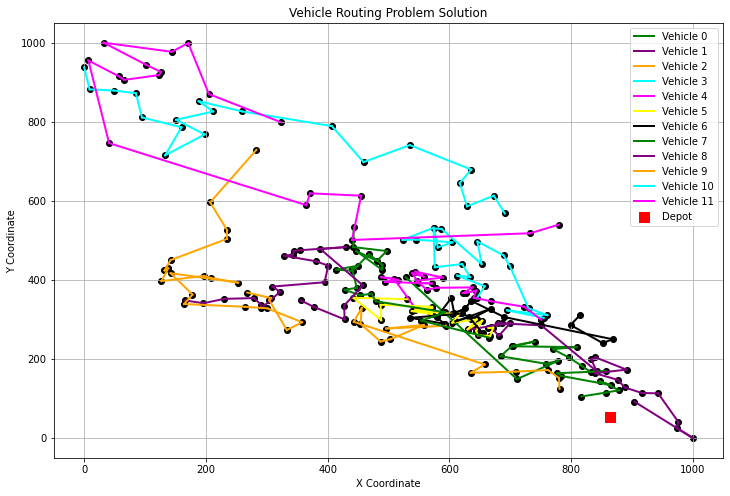

In [61]:
visualize_routes(initial_solution,instance["node_coord"])

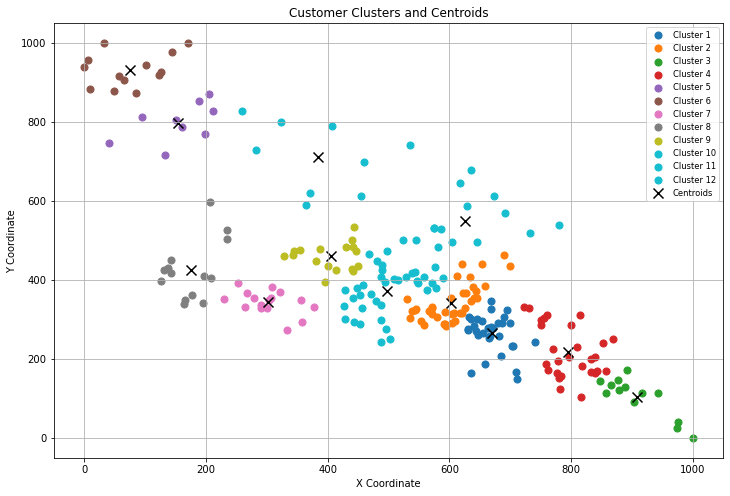

Allowed arcs based on distance threshold (791.3252829807409):
118 vs. 58564


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform

def hierarchical_clustering(coordinates, percentile=70):
    """
    Performs hierarchical clustering on customer coordinates with a dynamic distance threshold.
    
    Args:
    - coordinates (list of tuple): List of coordinates.
    - percentile (int): Percentile to determine the distance threshold dynamically.
    
    Returns:
    - labels (list of int): Cluster labels for each coordinate.
    """
    # Calculate the pairwise distances
    pairwise_distances = pdist(coordinates)
    
    # Determine the max_d threshold based on the percentile of pairwise distances
    max_d = np.percentile(pairwise_distances, percentile)

    # Perform hierarchical clustering
    Z = linkage(coordinates, method='ward')
    labels = fcluster(Z, max_d, criterion='distance')
    return labels

def compute_centroids(coordinates, labels):
    """
    Computes the centroids of clusters.
    """
    coordinates = np.array(coordinates)
    centroids = []
    unique_labels = set(labels)
    
    for label in unique_labels:
        cluster_points = coordinates[np.array(labels) == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)

    return np.array(centroids)

def calculate_distances(centroids):
    """
    Calculates the pairwise distances between cluster centroids.
    """
    return squareform(pdist(centroids))

def eliminate_arcs(coordinates, labels, percentile_threshold=90):
    """
    Eliminates arcs between clusters based on the distance of their centroids.
    
    Args:
    - coordinates (list of tuple): List of coordinates.
    - labels (list of int): Cluster labels for each coordinate.
    - percentile_threshold (int): Percentile for distance threshold.
    
    Returns:
    - allowed_arcs (dict): Dictionary of allowed arcs.
    - distance_threshold (float): Calculated distance threshold.
    """
    # Calculate centroids
    centroids = compute_centroids(coordinates, labels)

    # Calculate distances between centroids
    distance_matrix = calculate_distances(centroids)

    # Determine the distance threshold using the 90th percentile
    distance_threshold = np.percentile(distance_matrix, percentile_threshold)

    # Create a dictionary to store allowed arcs
    allowed_arcs = {}

    # Iterate through each pair of clusters
    for i, centroid_i in enumerate(centroids):
        for j, centroid_j in enumerate(centroids):
            if i != j and distance_matrix[i, j] <= distance_threshold:
                allowed_arcs[(i, j)] = distance_matrix[i, j]

    return allowed_arcs, distance_threshold

def visualize_clusters(coordinates, labels, centroids):
    """
    Visualizes clusters and their centroids.
    """
    plt.figure(figsize=(12, 8))
    coordinates = np.array(coordinates)
    unique_labels = set(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    for label in unique_labels:
        cluster_points = coordinates[np.array(labels) == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors(label), label=f'Cluster {label}', s=50)

    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.title('Customer Clusters and Centroids')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.show()

# Example usage
coordinates = instance["node_coord"][1:]

# Perform clustering with dynamic threshold
labels = hierarchical_clustering(coordinates, percentile=75)

# Calculate centroids
centroids = compute_centroids(coordinates, labels)

# Eliminate arcs
allowed_arcs, threshold = eliminate_arcs(coordinates, labels, percentile_threshold=90)

# Visualize clusters
visualize_clusters(coordinates, labels, centroids)

print(f"Allowed arcs based on distance threshold ({threshold}):")
print(len(allowed_arcs),"vs.", len(demand)* len(demand) )


In [17]:
#def solve_cvrp_gurobi(instance,vehicle_count=round(sum(instance["demand"])/ instance["capacity"]*2)):


# Unpack instance information
vehicle_count=round(sum(instance["demand"])/ instance["capacity"]*2)
edge_weight = instance["edge_weight"]
demand = instance["demand"]
node_count = len(demand)
vehicle_capacity = instance["capacity"]

# Create a new Gurobi model
model = gp.Model("CVRP")

# Enable Gurobi logs
model.setParam('OutputFlag', 1)


# Create variables
x = model.addVars(node_count, node_count, vehicle_count, vtype=GRB.BINARY, name="x")
u = model.addVars(node_count, vehicle_count, vtype=GRB.CONTINUOUS, lb=0, name="u")


# Get the warm start solution from nearest neighbor
initial_solution = nearest_neighbor_with_2opt(instance)


# Set objective: Minimize the total distance traveled
model.setObjective(gp.quicksum(edge_weight[i][j] * x[i, j, k] 
                                for i in range(node_count) 
                                for j in range(node_count) 
                                for k in range(vehicle_count)), GRB.MINIMIZE)

# Constraints

# Each customer must be visited exactly once by exactly one vehicle
model.addConstrs((gp.quicksum(x[i, j, k] for j in range(node_count) 
                for k in range(vehicle_count) 
                if i != j) == 1 for i in range(1, node_count)), name="visit_once")

# Flow conservation at the depot
model.addConstrs((gp.quicksum(x[0, j, k] for j in range(1, node_count)) == 1 
                for k in range(vehicle_count)), name="leave_depot")
model.addConstrs((gp.quicksum(x[i, 0, k] for i in range(1, node_count)) == 1 
                for k in range(vehicle_count)), name="return_depot")

# Capacity constraints
model.addConstrs((gp.quicksum(demand[i] * x[i, j, k] for i in range(node_count) 
                for j in range(1, node_count)) <= vehicle_capacity 
                for k in range(vehicle_count)), name="capacity")


# Initialize u[0, k] = 0 for all vehicles at the depot
model.addConstrs((u[0, k] == 0 for k in range(vehicle_count)), name="depot_u")


# Flow balance constraints for each node and vehicle
model.addConstrs(
    (gp.quicksum(x[i, j, k] for j in range(node_count) if i != j) == gp.quicksum(x[j, i, k] for j in range(node_count) if i != j) 
        for i in range(1, node_count) for k in range(vehicle_count)), 
    name="flow_balance")

# Subtour elimination constraints (MTZ constraints)
model.addConstrs((u[i, k] - u[j, k] + vehicle_capacity * x[i, j, k] <= vehicle_capacity - demand[j] 
                 for i in range(1, node_count) 
                 for j in range(1, node_count) 
                 for k in range(vehicle_count) 
                 if i != j), name="mtz_subtour_elimination")


# Set bounds for u variables (for MTZ subtour elimination)
model.addConstrs((u[i, k] >= demand[i] for i in range(1, node_count) for k in range(vehicle_count)), name="u_lower_bound")
model.addConstrs((u[i, k] <= vehicle_capacity for i in range(1, node_count) for k in range(vehicle_count)), name="u_upper_bound")


# Optimize the model
model.optimize()

# Extract the solution
if model.status == GRB.OPTIMAL:
    solution = {}
    for k in range(vehicle_count):
        route = []
        current_node = 0  # Start from the depot
        while True:
            next_node = None
            for j in range(node_count):
                if j != current_node and x[current_node, j, k].x > 0.5:
                    route.append(j)
                    next_node = j
                    break
            if next_node is None or next_node == 0: # If no more nodes to visit, or return to depot
                break
            current_node = next_node
        solution[k] = route
#         return solution
else:
    print("No optimal solution found")
#        return None





Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300HF CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1405849 rows, 1411344 columns and 9763416 nonzeros
Model fingerprint: 0x748b8ad3
Variable types: 5808 continuous, 1405536 integer (1405536 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 11592 rows and 5832 columns (presolve time = 5s) ...
Presolve removed 11592 rows and 5832 columns (presolve time = 10s) ...
Presolve removed 11592 rows and 5832 columns (presolve time = 15s) ...
Presolve removed 11592 rows and 5832 columns (presolve time = 20s) ...
Presolve removed 11592 rows and 5832 columns (presolve time = 25s) ...
Presolve removed 11592 rows and 5832 columns (presolve time = 31s) ...


In [ ]:
for k in range(vehicle_count):
    for i in range(node_count):
        for j in range(node_count):
            if x[i,j,k].x > 0.5:
                print("vehicle: ",k, "nodes: ",i,j, )

vehicle:  0 nodes:  0 187
vehicle:  0 nodes:  10 38
vehicle:  0 nodes:  25 81
vehicle:  0 nodes:  26 230
vehicle:  0 nodes:  31 38
vehicle:  0 nodes:  33 114
vehicle:  0 nodes:  34 56
vehicle:  0 nodes:  35 14
vehicle:  0 nodes:  60 72
vehicle:  0 nodes:  62 36
vehicle:  0 nodes:  116 239
vehicle:  0 nodes:  139 0
vehicle:  0 nodes:  184 182
vehicle:  0 nodes:  212 134
vehicle:  1 nodes:  0 187
vehicle:  1 nodes:  3 227
vehicle:  1 nodes:  29 227
vehicle:  1 nodes:  37 73
vehicle:  1 nodes:  66 57
vehicle:  1 nodes:  88 124
vehicle:  1 nodes:  90 96
vehicle:  1 nodes:  94 101
vehicle:  1 nodes:  143 0
vehicle:  2 nodes:  0 187
vehicle:  2 nodes:  4 24
vehicle:  2 nodes:  23 60
vehicle:  2 nodes:  28 98
vehicle:  2 nodes:  30 60
vehicle:  2 nodes:  43 45
vehicle:  2 nodes:  71 45
vehicle:  2 nodes:  72 60
vehicle:  2 nodes:  77 112
vehicle:  2 nodes:  82 227
vehicle:  2 nodes:  85 98
vehicle:  2 nodes:  86 48
vehicle:  2 nodes:  93 73
vehicle:  2 nodes:  95 135
vehicle:  2 nodes:  96 90